# CV Final Project
- Computer Vision, Deep learning and Machine learning

## Name: Mbabazi Elizabeth Shirley
## REG No: 2022/HD05/1763U
## Student No: 2200701763

## Let us import packages

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage import io, color, transform
import numpy as np
import os
import cv2

## Extract images from video

In [3]:
import cv2
import os

def SimilarityCalculation(frame1, frame2):
    # Calculate the mean squared error (MSE) between two frames
    mse = ((frame1 - frame2) ** 2).mean()

    # Define a threshold for similarity
    threshold = 1000

    # If the MSE is below the threshold, frames are considered similar
    if mse < threshold:
        return True

    return False

def FramesExtraction(video_path, output_folder, frame_rate):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Read the video using OpenCV
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    save_count = 0

    previous_frame = None

    while cap.isOpened():
        # Read the next frame
        ret, frame = cap.read()

        if not ret:
            break

        # Convert the frame from BGR to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        if frame_count % frame_rate == 0:
            # Save the frame
            output_path = os.path.join(output_folder, f"frame_{save_count}.jpg")
            cv2.imwrite(output_path, frame)
            save_count += 1

#         if previous_frame is not None and calculate_similarity(previous_frame, rgb_frame):
#             # Skip similar frames
#             continue

        previous_frame = rgb_frame.copy()

        frame_count += 1

    cap.release()

    print(f"Frames extracted: {save_count}")

In [4]:

# # Example usage:
video_path = "Garden-Video.mp4"
output_folder = "image-dump"
frame_rate = 90

FramesExtraction(video_path, output_folder, frame_rate)


## Clustering the images into four clusters

In [4]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.cluster import AgglomerativeClustering
from shutil import move #You can use 'copy' if you want to keep the original

# Load the ResNet50 model with the final dense layer removed.
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Function to extract features from an image
def FeatureExtraction(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = model.predict(img_data)
    return features[0]

# Define path to the dump folder
folder_path = 'All-Images/Groupings'

# Extract features for all images in the dump folder
image_features = {}
for img_name in os.listdir(folder_path):
    if not img_name.startswith('.'):  # ignore hidden files
        img_path = os.path.join(folder_path, img_name)
        image_features[img_name] = FeatureExtraction(img_path)

# Convert dictionary to list for use with scikit-learn
ListOfFeatures = list(image_features.values())
ListOfImageNames = list(image_features.keys())

# Cluster the images using Agglomerative Clustering
ac = AgglomerativeClustering(n_clusters=4)
labels = ac.fit_predict(feature_list)

# Create subfolders within the dump folder for the clusters
for cluster_id in set(labels):
    cluster_folder = os.path.join(folder_path, f'cluster_{cluster_id}')
    os.makedirs(cluster_folder, exist_ok=True)

# Copy images to their respective cluster folders
for img_name, cluster_id in zip(ListOfImageNames, labels):
    move(os.path.join(folder_path, img_name), os.path.join(folder_path, f'cluster_{cluster_id}', img_name))


1/1 [==============================] - 0s 82ms/step


- Import that dataset

In [5]:
# Path to the dataset
dataset_path = 'CropSamples'
image_size = 100  # size to resize images to
n_neighbors = 3  # Number of neighbors for kNN
categories = ['banana', 'coffee', 'sugarcane']

### Let us have a look at the dataset.

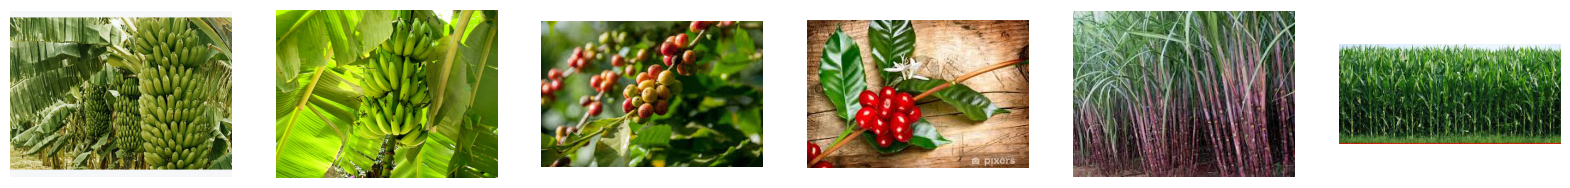

In [193]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import math

# Define directories for each category

dir1 = "CropSamples/coffee"
dir2 = "CropSamples/sugarcane"
dir3 = "CropSamples/banana"


# Load images from each category
images1 = [Image.open(os.path.join(dir1, img)) for img in os.listdir(dir1)][:2]
images2 = [Image.open(os.path.join(dir2, img)) for img in os.listdir(dir2)][:2]
images3 = [Image.open(os.path.join(dir3, img)) for img in os.listdir(dir3)][:2]

# Combine all images
all_images = images1 + images2 + images3

# Define grid size
cols = 6  # Number of columns
rows = math.ceil(len(all_images) / cols)  # Number of rows based on the number of images and desired columns

plt.figure(figsize=(20, 20))

# Plot each image in a grid
for i, img in enumerate(all_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.show()


## Image preprocessing

In [7]:

# Function to preprocess images
def ImagePreprocessing(image_path):
    try:
        img = io.imread(image_path)
    except Exception as e:
        print(f"Unable to open {image_path}: {e}")
        return None

    if img is not None:
        if img.shape[2] == 4:  # Check if image has alpha channel
            img = img[:,:,:3]  # Discard alpha channel
        img_gray = color.rgb2gray(img)  # Convert to grayscale
        img_resized = transform.resize(img_gray, 
                                       (image_size, image_size), 
                                       mode='symmetric', 
                                       preserve_range=True)  # Resize image
        return img_resized.flatten()

    return None


# Load images and labels
images = []
labels = []

for category in categories:
    for file in os.listdir(os.path.join(dataset_path, category)):
        if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg"):
            image_path = os.path.join(dataset_path, category, file)
            processed = preprocess_image(image_path)
            if processed is not None:
                images.append(processed)
                labels.append(category)


# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

## Split the data 

In [8]:
# Split data into train and test sets
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.3, random_state=0)

# Using naive Bayes

In [11]:
from sklearn.naive_bayes import GaussianNB

# Initialize and train the Gaussian Naive Bayes model
Gnb = GaussianNB()
Gnb.fit(images_train, labels_train)

# Predict the labels for the test set
Gnb_labels_pred = Gnb.predict(images_test)

# Evaluate the model
print('Accuracy:', accuracy_score(labels_test, Gnb_labels_pred))
# print('Confusion Matrix:\n', confusion_matrix(labels_test, gnb_labels_pred))
print('Classification Report:\n', classification_report(labels_test, Gnb_labels_pred))

Accuracy: 0.5769230769230769
Classification Report:
               precision    recall  f1-score   support

      banana       0.71      0.50      0.59        10
      coffee       0.64      0.78      0.70         9
   sugarcane       0.38      0.43      0.40         7

    accuracy                           0.58        26
   macro avg       0.58      0.57      0.56        26
weighted avg       0.60      0.58      0.58        26



### Confusion metrics

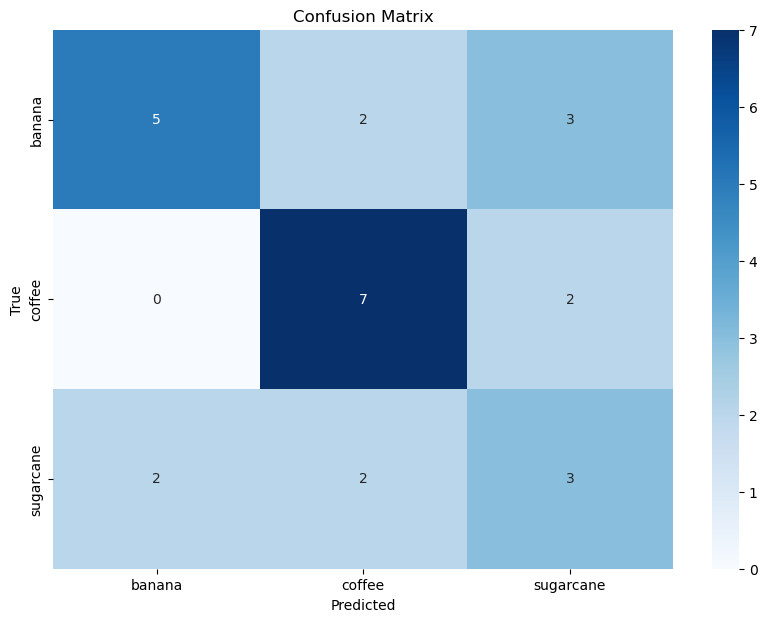

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
cm = confusion_matrix(labels_test, gnb_labels_pred)

# Plot the confusion matrix in a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=categories, yticklabels=categories, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Cleaning of the image dataset

### Image annotation or Cropping

In [13]:
import cv2
import os

def annotate_images(input_folder, output_folder):
    # Iterate through the items in the input folder
    for item in os.listdir(input_folder):
        item_path = os.path.join(input_folder, item)
        
        # Check if the item is a subfolder
        if os.path.isdir(item_path):
            # Create the corresponding output folder
            output_category_path = os.path.join(output_folder, item)
            os.makedirs(output_category_path, exist_ok=True)
            
            # Iterate through the images in the category folder
            for image_name in os.listdir(item_path):
                image_path = os.path.join(item_path, image_name)
                
                # Read the image using OpenCV
                image = cv2.imread(image_path)
                
                # Perform cropping or annotation on the image
                # Modify the following lines to suit your cropping or annotation needs
                
                # Example: Crop the image to a specific region of interest (ROI)
                roi = image[100:300, 200:400]  # Define the ROI coordinates (y1:y2, x1:x2)
                
                # Example: Add a rectangle annotation to the image
                cv2.rectangle(image, (200, 100), (400, 300), (0, 255, 0), 2)  # Define the rectangle coordinates
                
                # Save the cropped or annotated image to the output folder
                output_image_path = os.path.join(output_category_path, image_name)
                
                # Choose which version of the image to save (cropped or annotated)
                # Uncomment the desired line based on your requirements
                
                # Save the cropped image
                # cv2.imwrite(output_image_path, roi)
                
                # Save the annotated image
                cv2.imwrite(output_image_path, image)
    
    print("---> Image cropping/annotation completed.")


In [14]:

# Usage:
input_folder = "CropSamples"
output_folder = "CleanImages/Annotated"

annotate_images(input_folder, output_folder)


---> Image cropping/annotation completed.


In [47]:
# Function to preprocess images
def OriginalImagePreprocessing(img):
    if img.shape[2] == 4:  # Check if image has alpha channel
        img = img[:,:,:3]  # Discard alpha channel
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img_resized = transform.resize(img_gray, 
                                   (image_size, image_size), 
                                   mode='symmetric', 
                                   preserve_range=True)  # Resize image
    return img_resized.flatten()


### Feature Extraction
- Color Histograms
- Texture Features
- Shape Features
- Leaf Features
- Edges
- SIFT
- SURF
- Pixel Values

In [114]:
# handle varing length
def StatisticsComputation(feature):
    # If there are no features, return an array of zeros
    if feature is None or len(feature) == 0:
        return np.zeros(5)

    # Compute the mean, standard deviation, min, max, and median of the descriptors
    mean = np.mean(feature)
    std = np.std(feature)
    min_val = np.min(feature)
    max_val = np.max(feature)
    median_val = np.median(feature)

    return np.array([mean, std, min_val, max_val, median_val])


In [124]:
import cv2
import numpy as np
import os
import pandas as pd
from skimage import feature, morphology
from matplotlib import pyplot as plt
import shutil

# define input and output directories
input_dir = "CleanImages/Annotated"
output_dir = "CleanImages/Features"

# function to extract color histogram
def color_histogram(img):
    hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    return hist.flatten()

# function to extract texture features
def texture_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    textures = feature.local_binary_pattern(gray, 8 * 3, 3, method="uniform")
    return textures.flatten()

# function to extract shape features
def shape_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _,thresh = cv2.threshold(gray,1,255,cv2.THRESH_BINARY)
    contours,_ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in contours]
    return np.array(areas)

# function to extract edges
def edge_detection(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray,50,150)
    return edges.flatten()

# function to extract SIFT
def sift_features(img):
    sift = cv2.SIFT_create()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, des = sift.detectAndCompute(gray,None)
    return des.flatten()

# function to extract ORB
def orb_features(img):
    orb = cv2.ORB_create()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, des = orb.detectAndCompute(gray, None)
    if des is not None:
        return des.flatten()
    else:
        return np.array([])

# function to extract pixel values
def pixel_values(img):
    return img.flatten()

# read all images and extract features
def FeatureExtraction(img_dir):
    features = []
    labels = []
    for foldername in os.listdir(img_dir):
        subfolder = os.path.join(img_dir, foldername)
        for filename in os.listdir(subfolder):
            file_path = os.path.join(subfolder, filename)
            img = cv2.imread(file_path)
            original_image = compute_statistics(preprocess_original_image(img))
            color_hist_features = compute_statistics(color_histogram(img))
            texture = compute_statistics(texture_features(img))
            shape = compute_statistics(shape_features(img))
            edges = compute_statistics(edge_detection(img))
            sift = compute_statistics(sift_features(img))
            orb = compute_statistics(orb_features(img))
            pixel_val = compute_statistics(pixel_values(img))

            features.append([original_image, color_hist_features, texture, shape, edges, sift, orb, pixel_val])
            labels.append(foldername)
            
             # save the edges image to another folder
#             edge_image_path = os.path.join(output_dir, foldername, filename)
#             if not os.path.exists(os.path.join(output_dir, foldername)):
#                 os.makedirs(os.path.join(output_dir, foldername))
#             edges_img = edges.reshape(img.shape[0], img.shape[1])
#             cv2.imwrite(edge_image_path, edges_img)
    return features,labels


In [125]:
# Save the extracted features into a pandas dataframe
final_features, final_labels = FeatureExtraction(input_dir)
features_data = pd.DataFrame(final_features, columns=['original', 'color_histogram', 'texture_features', 'shape_features', 'edges', 'sift', 'orb', 'pixel_values'])
# features_data.to_csv('plants_features.csv', index=False)

# Preview of the extracted features

In [101]:
# import matplotlib.pyplot as plt

# # assuming df is your dataframe and images is a list of your images

# # plot color histogram
# plt.figure(figsize=(14, 6))
# plt.subplot(241)
# plt.bar(np.arange(len(features_data['color_histogram'][0])), features_data['color_histogram'][0])
# plt.title('Color Histogram')

# # plot texture features
# plt.subplot(242)
# plt.plot(features_data['texture_features'][0])
# plt.title('Texture Features')

# # plot shape features
# # For shape features, we are just getting the areas of contours so we can't visualize them as an image
# plt.subplot(243)
# plt.bar(np.arange(len(features_data['shape_features'][0])), features_data['shape_features'][0])
# plt.title('Shape Features')

# # plot edges
# plt.subplot(244)
# plt.hist(features_data['edges'][0], bins=30)
# plt.title('Edges')


# plt.tight_layout()
# plt.show()


## Let us flatten the features and labels.

In [126]:
labels_flattened = np.array(final_labels)
features_flattened = np.array(final_features).reshape(len(final_features), -1)

In [168]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features_flattened, 
                                                                        labels_flattened, 
                                                                        test_size=0.4, 
                                                                        random_state=15)

#  Train Naive Bayes Model

In [169]:
from sklearn.naive_bayes import GaussianNB

# Initialize and train the Gaussian Naive Bayes model
mlNB = GaussianNB()
mlNB.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = mlNB.predict(X_test)

# Evaluate the model
print('Accuracy:', accuracy_score(y_test, y_pred))
# print('Confusion Matrix:\n', confusion_matrix(labels_test, gnb_labels_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.6764705882352942
Classification Report:
               precision    recall  f1-score   support

      banana       0.76      0.81      0.79        16
      coffee       0.67      1.00      0.80        10
   sugarcane       0.00      0.00      0.00         8

    accuracy                           0.68        34
   macro avg       0.48      0.60      0.53        34
weighted avg       0.56      0.68      0.61        34



## Confusion Metrics

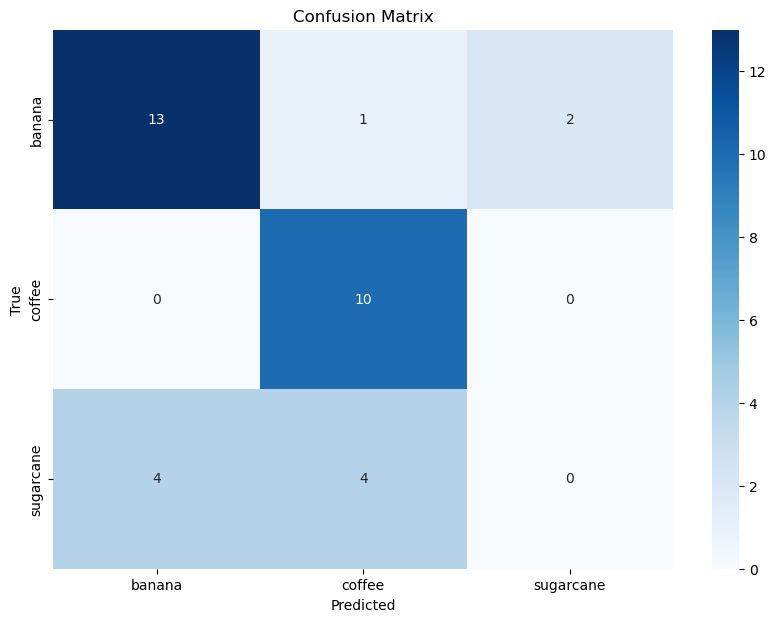

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix in a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=categories, yticklabels=categories, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Train CNN Model

- Define hyper parameters

In [219]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import seaborn as sn
import pandas as pd

#Define parameters
data_dir = 'cleaned-images/final'
# data_dir = 'sample-crops'
img_width, img_height = 150, 150  # adjust depending on your images
epochs = 20
batch_size = 16

- Data preprocessing

In [220]:
# this is the augmentation configuration we will use for training
datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)  # set validation split

# this will load images from the subfolders and automatically label them from the subfolder names
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')  # set as training data

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')  # set as validation data


Found 69 images belonging to 3 classes.
Found 16 images belonging to 3 classes.


- Define the CNN architecture

In [221]:
modelCNN = Sequential()
modelCNN.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 1), activation='relu'))  # grayscale so only 1 channel
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN.add(Conv2D(64, (3, 3), activation='relu'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN.add(Flatten())
modelCNN.add(Dense(64, activation='relu'))
modelCNN.add(Dense(3, activation='softmax'))  # assuming 3 classes

- Compile and train the model

In [218]:
modelCNN.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = modelCNN.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator)


Epoch 1/10
5/5 [==============================] - 2s 332ms/step - loss: 4.6618 - accuracy: 0.2319 - val_loss: 1.4105 - val_accuracy: 0.3125
Epoch 2/10
5/5 [==============================] - 1s 236ms/step - loss: 1.2169 - accuracy: 0.3478 - val_loss: 1.1146 - val_accuracy: 0.3750
Epoch 3/10
5/5 [==============================] - 1s 245ms/step - loss: 1.1037 - accuracy: 0.4203 - val_loss: 1.0973 - val_accuracy: 0.3750
Epoch 4/10
5/5 [==============================] - 1s 234ms/step - loss: 1.0956 - accuracy: 0.4783 - val_loss: 1.0980 - val_accuracy: 0.3125
Epoch 5/10
5/5 [==============================] - 1s 254ms/step - loss: 1.0983 - accuracy: 0.3333 - val_loss: 1.0978 - val_accuracy: 0.3125
Epoch 6/10
5/5 [==============================] - 1s 227ms/step - loss: 1.0836 - accuracy: 0.3768 - val_loss: 1.0848 - val_accuracy: 0.5000
Epoch 7/10
5/5 [==============================] - 1s 266ms/step - loss: 1.0622 - accuracy: 0.5217 - val_loss: 1.0537 - val_accuracy: 0.4375
Epoch 8/10
5/5 [====

In [206]:
# Get the true labels
Y_true = validation_generator.classes

# Use the model to predict (this will be the probabilities)
Y_pred_prob = modelCNN.predict(validation_generator)

# Get the predicted class
Y_pred = np.argmax(Y_pred_prob, axis=1)

# Print classification report
print(classification_report(Y_true, Y_pred, target_names=train_generator.class_indices.keys()))

1/1 [==============================] - 0s 432ms/step
              precision    recall  f1-score   support

      banana       0.25      0.17      0.20         6
      coffee       0.00      0.00      0.00         5
   sugarcane       0.44      0.80      0.57         5

    accuracy                           0.31        16
   macro avg       0.23      0.32      0.26        16
weighted avg       0.23      0.31      0.25        16



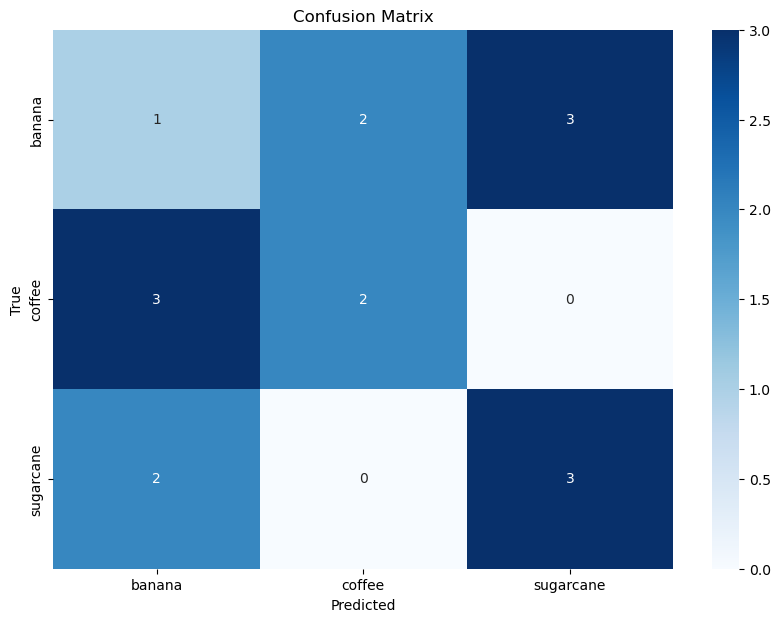

In [192]:
# cm = confusion_matrix(Y_true, Y_pred)
# df_cm = pd.DataFrame(cm, index = [i for i in train_generator.class_indices.keys()],
#                   columns = [i for i in train_generator.class_indices.keys()])
# plt.figure(figsize = (10,7))
# sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')


# Create the confusion matrix
cm = confusion_matrix(Y_true, Y_pred)

# Plot the confusion matrix in a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=categories, yticklabels=categories, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

- Please replace '/path/to/images' with the actual path of your images. The number '3' in the last layer's units denotes the number of classes you have. This example code assumes that you have 3 classes for your plants.

- If you want to split your data into training and validation sets, it is assumed that you already divided them manually into separate folders or you can use the validation_split parameter in ImageDataGenerator to automatically do it for you.

- This is a very simple CNN model, and it may not provide the best results depending on your dataset. For better results, consider tuning your model, adding more layers, or even using a pre-trained model like VGG16 or ResNet. Also, consider implementing image augmentation for better generalization and to prevent overfitting.

- Remember to ensure that the TensorFlow library is updated to the latest version to avoid any discrepancies.

- You should also note that the labels will be inferred from the directory structure of your base_dir, i.e., each subdirectory within base_dir will be taken to define a new class. The order of the classes will correspond to the lexicographic order of the subdirectory names. If you want to change this order, you can pass a classes argument to flow_from_directory method.

## Using a pretained model ResNet50

In [195]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import seaborn as sn
import pandas as pd

data_dir = 'cleaned-images/final'
img_width, img_height = 224, 224  # ResNet50 requires these dimensions
epochs = 20
batch_size = 16



- Split the data

In [196]:
datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')


Found 69 images belonging to 3 classes.
Found 16 images belonging to 3 classes.


- We will now load the pre-trained ResNet50 model, add a few layers to adapt it to our problem, and compile it:

In [197]:
base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)  # let's add a fully-connected layer as first layer
x = Dense(1024, activation='relu')(x)  # and a logistic layer with 3 classes as the last layer
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# freeze all convolutional ResNet50 layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 38s 0us/step


- Train the model:

In [198]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator)

Epoch 1/20
5/5 [==============================] - 8s 1s/step - loss: 4.0761 - accuracy: 0.2029 - val_loss: 1.3144 - val_accuracy: 0.3125
Epoch 2/20
5/5 [==============================] - 4s 818ms/step - loss: 1.5274 - accuracy: 0.3478 - val_loss: 1.8910 - val_accuracy: 0.3125
Epoch 3/20
5/5 [==============================] - 4s 817ms/step - loss: 1.7234 - accuracy: 0.2754 - val_loss: 1.0149 - val_accuracy: 0.5000
Epoch 4/20
5/5 [==============================] - 4s 872ms/step - loss: 1.0654 - accuracy: 0.4348 - val_loss: 1.1327 - val_accuracy: 0.5625
Epoch 5/20
5/5 [==============================] - 4s 841ms/step - loss: 1.1831 - accuracy: 0.4638 - val_loss: 1.4117 - val_accuracy: 0.3750
Epoch 6/20
5/5 [==============================] - 4s 855ms/step - loss: 1.2177 - accuracy: 0.3913 - val_loss: 1.2737 - val_accuracy: 0.5000
Epoch 7/20
5/5 [==============================] - 4s 1s/step - loss: 1.0324 - accuracy: 0.4783 - val_loss: 1.2903 - val_accuracy: 0.5000
Epoch 8/20
5/5 [==========

- Finally, evaluate the model and print the classification report and confusion matrix:

In [199]:
Y_true = validation_generator.classes
Y_pred_prob = model.predict(validation_generator)
Y_pred = np.argmax(Y_pred_prob, axis=1)

print(classification_report(Y_true, Y_pred, target_names=train_generator.class_indices.keys()))
print(confusion_matrix(Y_true, Y_pred))

1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

      banana       0.40      0.33      0.36         6
      coffee       0.33      0.60      0.43         5
   sugarcane       0.00      0.00      0.00         5

    accuracy                           0.31        16
   macro avg       0.24      0.31      0.26        16
weighted avg       0.25      0.31      0.27        16

[[2 3 1]
 [1 3 1]
 [2 3 0]]


- Plot the confusion matrix:

<AxesSubplot:>

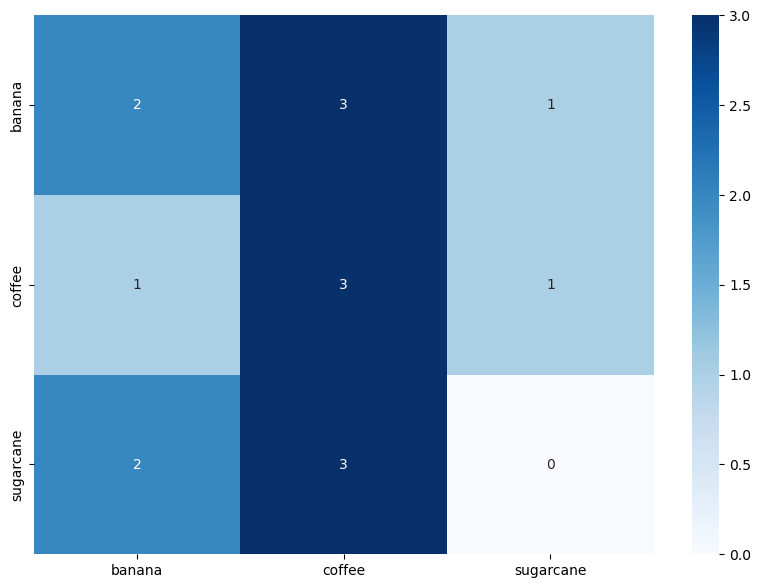

In [200]:
cm = confusion_matrix(Y_true, Y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in train_generator.class_indices.keys()],
                  columns = [i for i in train_generator.class_indices.keys()])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')